Analyse the resolved stellar populations
========================================

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle, Circle
import numpy as np
import pysunnc as ps
import os
import astropy.units as u
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from dust_extinction.parameter_averages import F04
from scipy import stats
import dynesty
from dynesty import plotting as dyplot
from multiprocessing import Pool

In [2]:
bspars=ps.pload('a_prep.bspars.dat')
snxy=ps.pload('a_prep.snxy.dat')
coeff=ps.pload('a_prep.coeff.dat')
print(bspars)
print(snxy)
print(coeff)

{'D': 14.4, 'eD': 1.3, 'DM': 30.8, 'eDM': 0.2, 'z': 0.00508, 'galebv': 0.02}
{'hst': (2764.84, 1885.33), 'muse': (201.27, 201.04)}
{2.0: {'F438W': 1.508, 'F555W': 1.067, 'F625W': 0.736, 'F814W': 0.388}, 3.1: {'F438W': 1.33, 'F555W': 1.051, 'F625W': 0.828, 'F814W': 0.549}, 4.0: {'F438W': 1.257, 'F555W': 1.042, 'F625W': 0.865, 'F814W': 0.614}, 4.7: {'F438W': 1.219, 'F555W': 1.037, 'F625W': 0.884, 'F814W': 0.648}, 5.0: {'F438W': 1.206, 'F555W': 1.035, 'F625W': 0.89, 'F814W': 0.66}, 6.0: {'F438W': 1.172, 'F555W': 1.03, 'F625W': 0.907, 'F814W': 0.69}}


**gas extinction**

In [3]:
dx=200
dy1=200
dy2=140

nx=2*dx
ny=dy1+dy2

xxs=-1*(np.arange(1, 2*dx+1+1)-snxy['muse'][0])
yys=np.arange(1, dy1+dy2+1+1)-snxy['muse'][1]

In [4]:
gsAv_img=fits.getdata('../muse/ngc4666im.line.pmap.fits', 3)

**Stellar catalogue**

In [5]:
bds=['F438W', 'F555W', 'F625W', 'F814W']

In [6]:
tabF=ascii.read('b_hst.cat.dat')

In [7]:
Avbin=0.2
LAbin=0.02
Avs=np.around(np.arange(0.0, 3.6+1e-3, Avbin), 1) # 18+1
LAs=np.around(np.arange(6.5, 7.5+1e-3, LAbin), 2) # 50+1
Avmesh=np.zeros((len(Avs), len(LAs)), dtype=float)
LAmesh=np.zeros((len(Avs), len(LAs)), dtype=float)
for iAv in range(len(Avs)):
    for iLA in range(len(LAs)):
        Avmesh[iAv, iLA]=Avs[iAv]
        LAmesh[iAv, iLA]=LAs[iLA]

**isochrones**

In [8]:
Rv0=4.7
# Rv0=3.1
# Rv0=6.0
cef0=coeff[Rv0]
LAs_all=np.around(np.arange(6.5, 7.5+1e-3, 0.01), 2) # 50+1
pts=ascii.read('../iso/isoall.dat')
pts=pts['LogA', 'Mini', 'F438Wmag', 'F555Wmag', 'F625Wmag', 'F814Wmag']
pts['LogA']=np.around(pts['LogA'], 2)
pts=[pts[np.abs(pts['LogA']-LAs_all[iLA])<1e-5] for iLA in range(len(LAs_all))]

**Functions**

In [14]:
def plotcmd(ax1, ax2, ax3, tabA, title):
    mfc='0.5'
    for ibd in range(len(bds)-1):
        ax=[ax1, ax2, ax3][ibd]
        ax.set_xlim(-3.5, 5.5)
        ax.set_ylim(30, 20)
        ax.set_xlabel(bds[ibd]+'-'+bds[ibd+1]+' (mag)', fontsize=13.5)
        ax.set_ylabel(bds[ibd+1]+' (mag)', fontsize=13.5)
        ax.set_title(title, fontsize=15.0)
        idx=np.logical_and(tabA['det'+bds[ibd]]==1, tabA['det'+bds[ibd+1]]==1)
        mag1=tabA[idx]['mag'+bds[ibd]]
        mag2=tabA[idx]['mag'+bds[ibd+1]]
        err1=tabA[idx]['err'+bds[ibd]]
        err2=tabA[idx]['err'+bds[ibd+1]]
        ax.errorbar(mag1-mag2, mag2,
                    xerr=np.sqrt(err1**2+err2**2),
                    yerr=err2,
                    fmt='o', markersize=5, mew=0.5, mec='k', mfc=mfc,
                    elinewidth=0.5, ecolor='0.3', zorder=3)
        idx=np.logical_and(tabA['det'+bds[ibd]]==0, tabA['det'+bds[ibd+1]]==1)
        mag1=tabA[idx]['mag'+bds[ibd]]
        mag2=tabA[idx]['mag'+bds[ibd+1]]
        err1=tabA[idx]['err'+bds[ibd]]
        err2=tabA[idx]['err'+bds[ibd+1]]
        ax.errorbar(mag1-mag2, mag2,
                    xerr=1.0,
                    yerr=err2,
                    xlolims=True,
                    fmt='o', markersize=5, mew=0.5, mec='k', mfc=mfc,
                    elinewidth=0.5, ecolor='0.3', zorder=3)
        idx=np.logical_and(tabA['det'+bds[ibd]]==1, tabA['det'+bds[ibd+1]]==0)
        mag1=tabA[idx]['mag'+bds[ibd]]
        mag2=tabA[idx]['mag'+bds[ibd+1]]
        err1=tabA[idx]['err'+bds[ibd]]
        err2=tabA[idx]['err'+bds[ibd+1]]
        ax.errorbar(mag1-mag2, mag2,
                    xerr=1.0,
                    yerr=1.0,
                    xuplims=True, lolims=True,
                    fmt='o', markersize=5, mew=0.5, mec='k', mfc=mfc,
                    elinewidth=0.5, ecolor='0.3', zorder=3)

In [161]:
def plotiso(ax1, ax2, ax3, pt0, cef0, Av0, popID, color):
    for ibd in range(len(bds)-1):
        ax=[ax1, ax2, ax3][ibd]
        mag1=pt0[bds[ibd]+'mag']+cef0[bds[ibd]]*Av0+bspars['DM']
        mag2=pt0[bds[ibd+1]+'mag']+cef0[bds[ibd+1]]*Av0+bspars['DM']
        ax.plot(mag1-mag2, mag2, zorder=100, linewidth=3, color='w')
        ax.plot(mag1-mag2, mag2, zorder=200, linewidth=2, color=color)
        if ibd==2:
            idxmin=np.argmin(mag2)
            ax.text(mag1[idxmin]-mag2[idxmin], mag2[idxmin],
                    '    Pop'+regname+popID, fontsize=14.5,
                    color=color, zorder=200)
        ax.arrow(-3, 21,
                 (cef0[bds[ibd]]-cef0[bds[ibd+1]])*Av0,
                 cef0[bds[ibd+1]]*Av0,
                 width=0.03,
                 length_includes_head=True,
                 head_width=0.2,
                 color='k')
        if ibd==2:
            ax.text(-3.5+(cef0[bds[ibd]]-cef0[bds[ibd+1]])*Av0,
                    21+cef0[bds[ibd+1]]*Av0+0.7,
                    'Av='+str(round(Av0, 2)), fontsize=12)
            ax.text(-3.5+(cef0[bds[ibd]]-cef0[bds[ibd+1]])*Av0,
                    21+cef0[bds[ibd+1]]*Av0+1.3,
                    'Rv=4.7', fontsize=12)

In [162]:
def Norm(x, mu, sig):
    return 1.0/np.sqrt(2*np.pi)/sig*np.exp(-0.5*((x-mu)/sig)**2)

**Population fitting**

In [163]:
STreg=ps.pload('b_reg.streg.dat')
def drawSTreg(**kwarg):
    x1, x2 = (-12, 17)
    y1, y2 = (-12, 18)
    ax.plot([x1, x2, x2, x1, x1],
            [y1, y1, y2, y2, y1], **kwarg)
    for rID in STreg.keys():
        cen=STreg[rID]['cen']
        rad=STreg[rID]['rad']
        ax.add_artist(Circle(cen, rad, fill=False, **kwarg))
        ax.text(*cen, rID, ha='center', va='center')

In [192]:
# regname, nComp = 'A', 3
# regname, nComp = 'B', 3
regname, nComp = 'C', 3
# regname, nComp = 'D', 2
# regname, nComp = 'E', 2
# regname, nComp = 'F', 2
filename='../results/c_pop.reg'+regname+str(int(Rv0*10))+'.dat'
x0, y0 = STreg[regname]['cen']
rad0 = STreg[regname]['rad']

In [193]:
# catalogue
tabA=tabF[np.sqrt((tabF['dxx']-x0)**2+(tabF['dyy']-y0)**2)<=rad0]
tabA=tabA[tabA['ID']!=1] # remove star cluster candidate

# gas extinction
gsAvs=[]
for iy in range(ny):
    for ix in range(nx):
        if np.sqrt((xxs[ix]-x0)**2+(yys[iy]-y0)**2)<=rad0:
            gsAvs.append(gsAv_img[iy, ix])
gsAvs=np.array(gsAvs)

ext47_model=F04(Rv=4.7)
eHbHa47_av=ext47_model(4861*u.angstrom)-ext47_model(6563*u.angstrom)
ext_model=F04(Rv=Rv0)
eHbHa_av=ext_model(4861*u.angstrom)-ext_model(6563*u.angstrom)

gsAv_mean, gsAv_med, gsAv_std = sigma_clipped_stats(gsAvs*eHbHa47_av/eHbHa_av)
gsAv_mean = round(gsAv_mean, 2)
gsAv_med = round(gsAv_med, 2)
gsAv_std = round(gsAv_std, 2)
print(gsAv_mean, gsAv_med, gsAv_std)

1.95 1.92 0.3


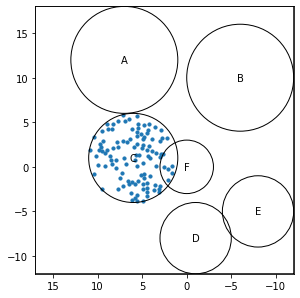

In [194]:
plt.close('all')
fig=plt.figure(figsize=[400/80, 340/80])
ax=fig.add_subplot(111)
ax.set_xlim(17, -12)
ax.set_ylim(-12, 18)
ax.set_aspect('equal')

drawSTreg(color='k')

ax.scatter(tabA['dxx'], tabA['dyy'], s=10)

fig.tight_layout()

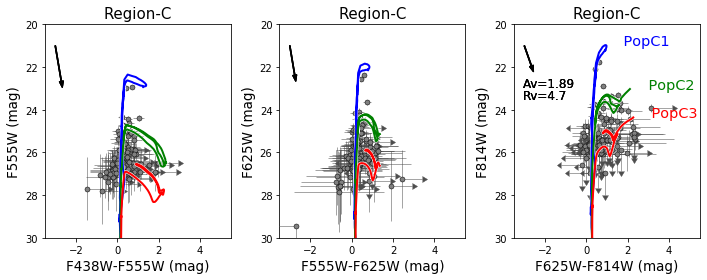

In [195]:
plt.close('all')
fig=plt.figure(figsize=[10, 4])
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
plotcmd(ax1, ax2, ax3, tabA, 'Region-'+regname)

if regname=='A':
    LA1, LA2, LA3, Av0 = 6.60, 7.00, 7.38, 1.64
if regname=='B':
    LA1, LA2, LA3, Av0 = 6.61, 7.00, 7.40, 1.79
if regname=='C':
    LA1, LA2, LA3, Av0 = 6.61, 7.00, 7.38, 1.89
if regname=='D':
    LA2, LA3, Av0 = 7.02, 7.39, 2.16
if regname=='E':
    LA2, LA3, Av0 = 7.00, 7.36, 1.77
if regname=='F':
    LA2, LA3, Av0 = 7.00, 7.39, 1.82

if nComp==3:
    pt1=pts[np.where(np.abs(LAs_all-LA1)<1e-5)[0][0]]
    plotiso(ax1, ax2, ax3, pt1, cef0, Av0, popID='1', color='blue')
pt2=pts[np.where(np.abs(LAs_all-LA2)<1e-5)[0][0]]
pt3=pts[np.where(np.abs(LAs_all-LA3)<1e-5)[0][0]]
plotiso(ax1, ax2, ax3, pt2, cef0, Av0, popID='2', color='green')
plotiso(ax1, ax2, ax3, pt3, cef0, Av0, popID='3', color='red')

fig.tight_layout()
fig.savefig('c_pop.cmd'+regname+'.pdf')

**Population fitting**

In [59]:
Pbin=0.5
posts=[]
for ii in range(len(tabA)):
    ID=tabA[ii]['ID']
    if Rv0==4.7:
        postsin=ps.pload('../results/xxpost/sin'+str(ID)+'.dat')
        postbin=ps.pload('../results/xxpost/bin'+str(ID)+'.dat')
    if Rv0==3.1:
        postsin=ps.pload('../results/xxpost3/sin'+str(ID)+'.dat')
        postbin=ps.pload('../results/xxpost3/bin'+str(ID)+'.dat')
    if Rv0==6.0:
        postsin=ps.pload('../results/xxpost6/sin'+str(ID)+'.dat')
        postbin=ps.pload('../results/xxpost6/bin'+str(ID)+'.dat')
    posts.append(postsin*(1-Pbin)+postbin*Pbin)

In [32]:
if nComp==3:
    # 3-component model: pop1 + pop2 + pop3 + Av=gsAv
    def ptform3(x):
        (xw1, xw2, xLA1, xLA2, xLA3, xAv)=x
        pw1=xw1*(1.0-0.0)+0.0
        pw2=xw2*(1.0-pw1-0.0)+0.0
        pLA1=xLA1*(np.amax(LAs)-np.amin(LAs))+np.amin(LAs)
        pLA2=xLA2*(np.amax(LAs)-(pLA1+0.1))+(pLA1+0.1)
        pLA3=xLA3*(np.amax(LAs)-(pLA2+0.1))+(pLA2+0.1)
        pAv=stats.truncnorm.ppf(xAv,
                                (np.amin(Avs)-gsAv_med)/0.05,
                                (np.amin(Avs)+gsAv_med)/0.05,
                                loc=gsAv_med, scale=0.05)
        return np.array([pw1, pw2, pLA1, pLA2, pLA3, pAv])

    def loglike3(x):
        (w1, w2, LA1, LA2, LA3, Av)=x
        w3=1.0-w1-w2
        LL=0.0
        for ii in range(len(posts)):
            Avnorm=Norm(Avmesh, Av, gsAv_std)
            LAnorm=Norm(LAmesh, LA1, 0.05)
            LL1=w1*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LAnorm=Norm(LAmesh, LA2, 0.05)
            LL2=w2*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LAnorm=Norm(LAmesh, LA3, 0.05)
            LL3=w3*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LL=LL+np.log(LL1+LL2+LL3)
        return LL
if nComp==2:
    # 2-component model: pop2 + pop3 + Av=gsAv
    def ptform2(x):
        (xw2, xLA2, xLA3, xAv)=x
        pw2=xw2*(1.0-0.0)+0.0
        if regname=='D' and Rv0==3.1:
            pLA2=xLA2*(np.amax(LAs)-6.8)+6.8
            pLA3=xLA3*(np.amax(LAs)-(pLA2+0.1))+(pLA2+0.1)
        elif regname=='E' and Rv0==6.0:
            pLA2=xLA2*(np.amax(LAs)-6.94)+6.94
            pLA3=xLA3*(np.amax(LAs)-7.28)+7.28
        elif regname=='F' and Rv0==4.7:
            pLA2=xLA2*(7.1-6.9)+6.9
            pLA3=xLA3*(np.amax(LAs)-7.2)+7.2
        elif regname=='F' and Rv0==3.1:
            pLA2=xLA2*(7.2-6.9)+6.9
            pLA3=xLA3*(np.amax(LAs)-7.2)+7.2
        elif regname=='F' and Rv0==6.0:
            pLA2=xLA2*(7.3-6.8)+6.8
            pLA3=xLA3*(np.amax(LAs)-7.15)+7.15
        else:
            pLA2=xLA2*(np.amax(LAs)-np.amin(LAs))+np.amin(LAs)
            pLA3=xLA3*(np.amax(LAs)-(pLA2+0.1))+(pLA2+0.1)
        pAv=stats.truncnorm.ppf(xAv,
                                (np.amin(Avs)-gsAv_med)/0.05,
                                (np.amin(Avs)+gsAv_med)/0.05,
                                loc=gsAv_med, scale=0.05)
        return np.array([pw2, pLA2, pLA3, pAv])

    def loglike2(x):
        (w2, LA2, LA3, Av)=x
        w3=1.0-w2
        LL=0.0
        for ii in range(len(posts)):
            Avnorm=Norm(Avmesh, Av, gsAv_std)
            LAnorm=Norm(LAmesh, LA2, 0.05)
            LL2=w2*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LAnorm=Norm(LAmesh, LA3, 0.05)
            LL3=w3*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LL=LL+np.log(LL2+LL3)
        return LL

In [19]:
flag=0
if flag==1:
    if nComp==3:
        sampler=dynesty.DynamicNestedSampler(loglike3, ptform3, ndim=6,
                                             pool=Pool(processes=48),
                                             queue_size=4)
        sampler.run_nested()
        results=sampler.results

    if nComp==2:
        sampler=dynesty.DynamicNestedSampler(loglike2, ptform2, ndim=4,
                                             pool=Pool(processes=48),
                                             queue_size=4)
        sampler.run_nested()
        results=sampler.results
    ps.pdump(results, filename)

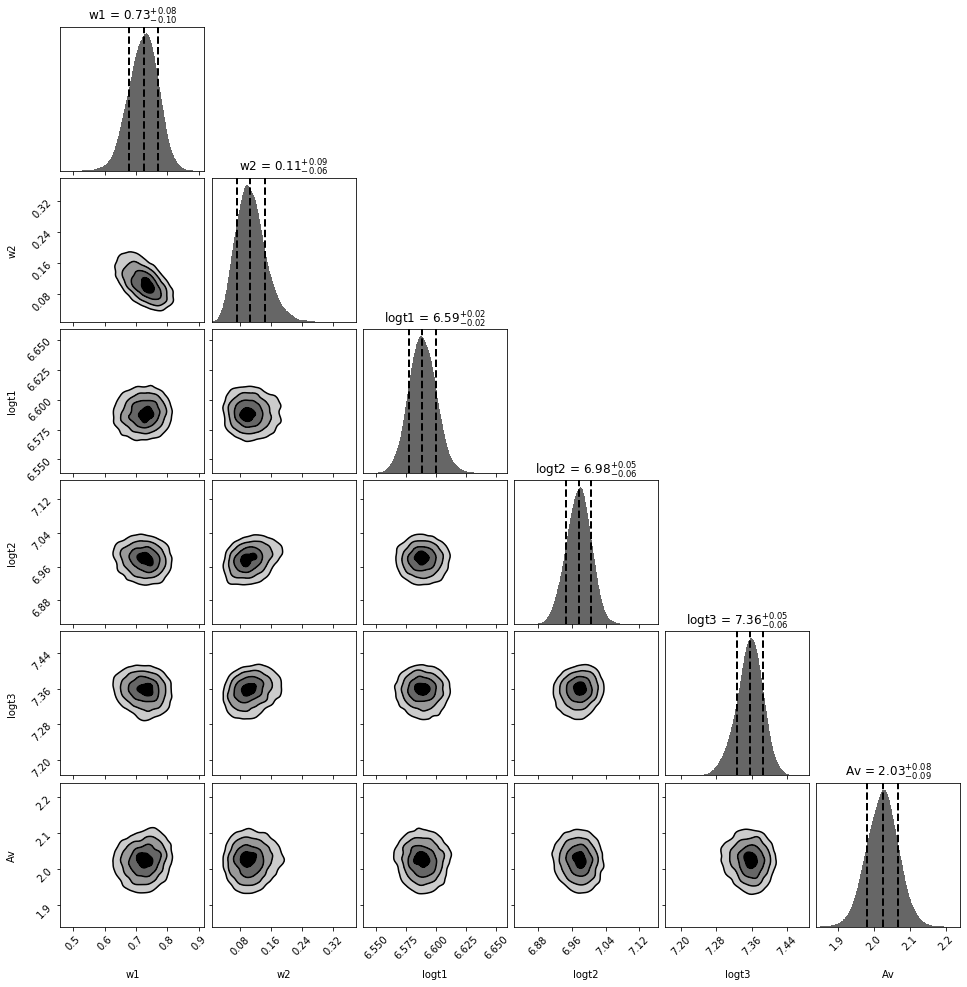

In [99]:
# results=ps.pload('../results/c_pop.regF31.dat')
labels=['w1', 'w2', 'logt1', 'logt2', 'logt3', 'Av']
# labels=['w2', 'logt2', 'logt3', 'Av']
plt.close('all')
(cfig, caxes)=dyplot.cornerplot(results, show_titles=True,
                                quantiles=[0.16, 0.5, 0.84],
                                labels=labels)
cfig.savefig(filename.replace('.dat', '.pdf'))

**Backups**

In [35]:
if nComp==3:
    # 3-component model: pop1 + pop2 + pop3 + Av=gsAv
    def ptform3(x):
        (xw1, xw2, xLA1, xLA2, xLA3, xAv)=x
        pw1=xw1*(1.0-0.0)+0.0
        pw2=xw2*(1.0-pw1-0.0)+0.0
        pLA1=xLA1*(np.amax(LAs)-np.amin(LAs))+np.amin(LAs)
        pLA2=xLA2*(np.amax(LAs)-(pLA1+0.1))+(pLA1+0.1)
        pLA3=xLA3*(np.amax(LAs)-(pLA2+0.1))+(pLA2+0.1)
        pAv=stats.truncnorm.ppf(xAv,
                                (np.amin(Avs)-gsAv_med)/0.05,
                                (np.amin(Avs)+gsAv_med)/0.05,
                                loc=gsAv_med, scale=0.05)
        return np.array([pw1, pw2, pLA1, pLA2, pLA3, pAv])

    def loglike3(x):
        (w1, w2, LA1, LA2, LA3, Av)=x
        w3=1.0-w1-w2
        LL=0.0
        for ii in range(len(posts)):
            Avnorm=Norm(Avmesh, Av, gsAv_std)
            LAnorm=Norm(LAmesh, LA1, 0.05)
            LL1=w1*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LAnorm=Norm(LAmesh, LA2, 0.05)
            LL2=w2*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LAnorm=Norm(LAmesh, LA3, 0.05)
            LL3=w3*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LL=LL+np.log(LL1+LL2+LL3)
        return LL
if nComp==2:
    # 2-component model: pop2 + pop3 + Av=gsAv
    def ptform2(x):
        (xw2, xLA2, xLA3, xAv)=x
        pw2=xw2*(1.0-0.0)+0.0
        if regname=='E' and Rv0==6.0:
            pLA2=xLA2*(np.amax(LAs)-6.9)+6.9
            pLA3=xLA3*(np.amax(LAs)-(pLA2+0.1))+(pLA2+0.1)
        elif regname=='F' and Rv0==4.7:
            pLA2=xLA2*(7.1-6.9)+6.9
            pLA3=xLA3*(np.amax(LAs)-7.2)+7.2
        elif regname=='F' and Rv0==3.1:
            pLA2=xLA2*(7.2-6.9)+6.9
            pLA3=xLA3*(np.amax(LAs)-7.2)+7.2
        elif regname=='F' and Rv0==6.0:
            pLA2=xLA2*(7.3-6.8)+6.8
            pLA3=xLA3*(np.amax(LAs)-7.15)+7.15
        else:
            pLA2=xLA2*(np.amax(LAs)-np.amin(LAs))+np.amin(LAs)
            pLA3=xLA3*(np.amax(LAs)-(pLA2+0.1))+(pLA2+0.1)
        pAv=stats.truncnorm.ppf(xAv,
                                (np.amin(Avs)-gsAv_med)/0.05,
                                (np.amin(Avs)+gsAv_med)/0.05,
                                loc=gsAv_med, scale=0.05)
        return np.array([pw2, pLA2, pLA3, pAv])

    def loglike2(x):
        (w2, LA2, LA3, Av)=x
        w3=1.0-w2
        LL=0.0
        for ii in range(len(posts)):
            Avnorm=Norm(Avmesh, Av, gsAv_std)
            LAnorm=Norm(LAmesh, LA2, 0.05)
            LL2=w2*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LAnorm=Norm(LAmesh, LA3, 0.05)
            LL3=w3*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
            LL=LL+np.log(LL2+LL3)
        return LL
# if regname=='F':
#     # 2-component model: pop2 + pop3 + Av=gsAv
#     def ptform2(x):
#         (xw2, xLA2, xLA3, xAv)=x
#         pw2=xw2*(1.0-0.0)+0.0
#         if Rv0==4.7:
#             pLA2=xLA2*(7.1-6.9)+6.9
#             pLA3=xLA3*(np.amax(LAs)-7.2)+7.2
#         if Rv0==3.1:
#             pLA2=xLA2*(7.2-6.9)+6.9
#             pLA3=xLA3*(np.amax(LAs)-7.2)+7.2
#         if Rv0==6.0:
#             pLA2=xLA2*(7.3-6.8)+6.8
#             pLA3=xLA3*(np.amax(LAs)-7.15)+7.15
#         pAv=stats.truncnorm.ppf(xAv,
#                                 (np.amin(Avs)-gsAv_med)/0.05,
#                                 (np.amin(Avs)+gsAv_med)/0.05,
#                                 loc=gsAv_med, scale=0.05)
#         return np.array([pw2, pLA2, pLA3, pAv])

#     def loglike2(x):
#         (w2, LA2, LA3, Av)=x
#         w3=1.0-w2
#         LL=0.0
#         for ii in range(len(posts)):
#             Avnorm=Norm(Avmesh, Av, gsAv_std)
#             LAnorm=Norm(LAmesh, LA2, 0.05)
#             LL2=w2*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
#             LAnorm=Norm(LAmesh, LA3, 0.05)
#             LL3=w3*(np.sum(posts[ii]*Avnorm*LAnorm)*Avbin*LAbin)
#             LL=LL+np.log(LL2+LL3)
#         return LL